<a href="https://colab.research.google.com/github/senanayake/colab-notebooks/blob/main/sports_betting_core_concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sports Betting Core Concepts – Interactive Notebook

This notebook is designed for **learning and intuition-building**, not for gambling advice.

You can run it in **Google Colab** or any Jupyter environment. Work through the sections in order, play with the parameters, and observe how the math behaves.

---
## Table of Contents
1. Setup & Helpers  
2. Randomness, Probability & Law of Large Numbers  
3. Odds Formats & Conversions  
4. Implied Probability  
5. Vig (Juice) & Overround  
6. Expected Value (EV)  
7. Bankroll Management & Kelly Criterion  
8. Variance, Drawdowns & Risk of Ruin (Simulations)  
9. Parlays  
10. Wrap-up Playground


In [ ]:
# 1. Setup & Helpers
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)

# Helper to display as percentage
def pct(x, decimals=2):
    return round(100 * x, decimals)

print("Environment ready.")

Environment ready.


## 2. Randomness, Probability & Law of Large Numbers

We’ll start with simple coin flips and dice to show:
- The difference between **true probability** and **observed frequency**
- How the **law of large numbers** pulls frequencies toward the true probability over many trials

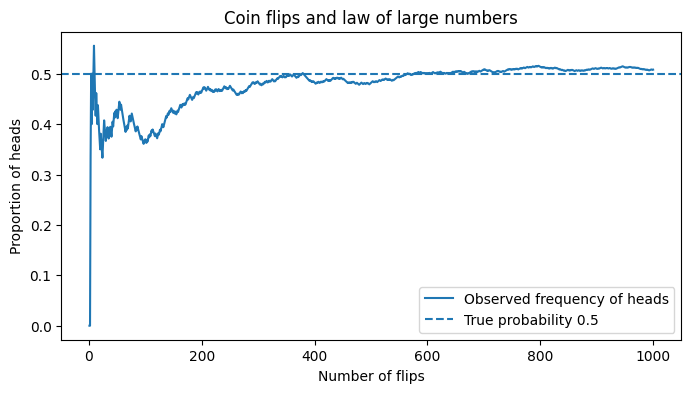

In [ ]:
# Coin flip simulation – law of large numbers

def simulate_coin_flips(n_flips=1000, p_heads=0.5, seed=0):
    random.seed(seed)
    heads_count = 0
    freqs = []
    for i in range(1, n_flips + 1):
        if random.random() < p_heads:
            heads_count += 1
        freqs.append(heads_count / i)
    return freqs

n_flips = 1000
freqs = simulate_coin_flips(n_flips=n_flips)

plt.plot(range(1, n_flips + 1), freqs, label="Observed frequency of heads")
plt.axhline(0.5, linestyle="--", label="True probability 0.5")
plt.xlabel("Number of flips")
plt.ylabel("Proportion of heads")
plt.title("Coin flips and law of large numbers")
plt.legend()
plt.show()

Try changing `n_flips` above (e.g. 50, 200, 10_000) and see how the line behaves.

---
## 3. Odds Formats & Conversions

We’ll support the most common formats:
- **American** (e.g. `-150`, `+200`)
- **Decimal** (e.g. `1.50`, `2.25`)
- **Fractional** (e.g. `5/2`, `1/4`)

You can expand to Hong Kong, Indonesian, Malay odds later using similar patterns.

## Learning Section

🎯 **Goal: Understand why implied probability = risk / (risk + reward)**

To understand why implied probability uses the formula

$$P = \frac{\text{risk}}{\text{risk} + \text{reward}}$$

it helps to compare sports betting to something we already understand deeply: **coin tosses and dice**.

---

### 1. Probability is always “favorable outcomes ÷ total outcomes”

For a fair coin:

- 1 way to win (heads)  
- 1 way to lose (tails)

$$P(\text{win}) = \frac{1}{1 + 1} = \frac{1}{2}$$

For a fair six-sided die:

- 1 winning side (roll a 6)  
- 5 losing sides  

$$P(\text{win}) = \frac{1}{1 + 5} = \frac{1}{6}$$

In both cases:

$$\text{Probability} = \frac{\text{ways to win}}{\text{ways to win} + \text{ways to lose}}$$

This structure is the key.

---

### 2. Betting odds secretly create a *weighted game*

Sportsbooks do **not** show you the number of winning or losing outcomes.  
Instead, they show you:

- **risk** (how much you must bet and can lose)  
- **reward** (how much you profit if you're right)

These two numbers act like **weights** — just like the “ways to win/lose” on a die.

**Examples:**

- `+150` odds → risk = 100, reward = 150  
- `-200` odds → risk = 200, reward = 100  

Think of risk and reward as the sportsbook’s version of:

- “ways to lose” (risk)  
- “ways to win” (reward)

They define a little *weighted* game where:

- Losing is weighted by how much you risk  
- Winning is weighted by how much you profit  

---

### 3. Turning odds into an implied probability

Using the same structure as coins and dice:

$$P(\text{win}) = \frac{\text{win weight}}{\text{win weight} + \text{lose weight}}$$

For odds, we treat:

- **risk** as the *lose weight*  
- **reward** as the *win weight*

So the implied probability becomes:

$$P = \frac{\text{risk}}{\text{risk} + \text{reward}}$$

This is not arbitrary — it is the **break-even probability** when payouts are defined by risk and reward.

---

### 4. Example: +150 odds

You risk 100 to win 150.

So the weights are:

- Lose weight = 100  
- Win weight = 150  

$$P = \frac{100}{100 + 150} = \frac{100}{250} = 0.40$$

The sportsbook is effectively saying:

> “To break even in the long run at these payouts, your chance of **winning** must be about 40%.”

---

### 5. Example: –200 odds

You risk 200 to win 100.

$$P = \frac{200}{200 + 100} = \frac{200}{300} \approx 0.6667$$

Meaning:

> “To break even, you’d need to win about 2 out of 3 times.”

---

### 6. Why this structure is universal

- Coin → 1 win / 1 loss  
- Die → 1 win / 5 loss  
- Odds → reward / risk  

In all cases:

$$\text{Probability} = \frac{\text{win weight}}{\text{win weight} + \text{lose weight}}$$

Betting odds simply replace **outcome counts** with **money weights**.

That’s why this formula is not just convenient —  
it’s exactly how probability works in any weighted system.


In [ ]:
# Odds conversion helpers

def american_to_decimal(odds: int) -> float:
    """Convert American odds (e.g. -150, +200) to decimal odds."""
    if odds > 0:
        return 1 + odds / 100
    else:
        return 1 + 100 / abs(odds)

def decimal_to_american(d: float) -> int:
    """Convert decimal odds to American odds."""
    if d >= 2.0:
        return int(round((d - 1) * 100))  # positive odds
    else:
        return int(round(-100 / (d - 1)))  # negative odds

def fractional_to_decimal(frac: str) -> float:
    """Convert fractional odds like '5/2' to decimal."""
    num, den = frac.split("/")
    num, den = float(num), float(den)
    return 1 + num / den

def decimal_to_fractional(d: float, max_denominator: int = 100) -> str:
    """Approximate decimal odds as a fractional string."""
    from fractions import Fraction
    frac = Fraction(d - 1).limit_denominator(max_denominator)
    return f"{frac.numerator}/{frac.denominator}"

# Quick demo
examples = [
    ("American", -150),
    ("American", +200),
    ("Decimal", 1.5),
    ("Decimal", 2.5),
    ("Fractional", "5/2"),
]

for kind, value in examples:
    if kind == "American":
        d = american_to_decimal(value)
        print(f"American {value} -> Decimal {d:.3f} -> Fractional {decimal_to_fractional(d)}")
    elif kind == "Decimal":
        a = decimal_to_american(value)
        print(f"Decimal {value:.3f} -> American {a} -> Fractional {decimal_to_fractional(value)}")
    else:
        d = fractional_to_decimal(value)
        print(f"Fractional {value} -> Decimal {d:.3f} -> American {decimal_to_american(d)}")

American -150 -> Decimal 1.667 -> Fractional 2/3
American 200 -> Decimal 3.000 -> Fractional 2/1
Decimal 1.500 -> American -200 -> Fractional 1/2
Decimal 2.500 -> American 150 -> Fractional 3/2
Fractional 5/2 -> Decimal 3.500 -> American 250


## 🎲 What Are Implied Odds?

Implied odds tell you what a sportsbook thinks the chance of something happening is, based on the betting odds they give you.

It’s like the sportsbook is saying:

> “Because of the way we’ve priced this bet, we think this event has about a ___% chance of happening.”

You don’t have to agree — but that’s the *implied* chance hidden inside the odds.

---

## 📌 Why does this matter?

Because **if you think the real chance is better** than what the odds imply, the bet *might* be good.

If **you think the chance is worse**, it’s a bad bet.

It’s a comparison between:

- **What the odds say**
- **What you believe**

---

## 🎯 Example (Super Simple): +200 Odds

If the sportsbook lists **+200**, that means:

- Bet \$100 → Profit \$200  
- Total return = \$300  

Implied probability:

$$
P = \frac{100}{100 + 200} = \frac{100}{300} = 0.33 \text{ (33%)}
$$

Meaning the sportsbook thinks:

> “There is about a 1-in-3 chance this will happen.”

If **you think the real chance is higher**, like 50%, this is a good value bet.  
If **you think the chance is lower**, like 10%, it’s a bad bet.

---

## 🎯 Another Example: +150 Odds

Profit from \$100 = \$150  
Total return = \$250

Implied probability:

$$
P = \frac{100}{250} = 0.40 \text{ (40%)}
$$

So the sportsbook is implying:

> “We think this event happens about 40% of the time.”

---

## 🎯 Example (Negative Odds): –200

Odds: **–200**

Meaning:

- Bet \$200 → Profit \$100  
- Total return = \$300  

Implied probability:

$$
P = \frac{200}{200 + 100} = \frac{200}{300} = 0.667 \text{ (66.7%)}
$$

So the sportsbook is effectively saying:

> “We think this happens about 2 out of 3 times.”

---

## 🧠 Why “Implied”?

Because the sportsbook never tells you the actual probability.  
They *hide it inside the odds*.

You can decode their belief about the chance of an event by converting the odds to implied probability.

---

## 🌟 Simple Summary

- **Implied odds** tell you how likely an outcome is, based on the price the sportsbook sets.
- **Big positive odds** → sportsbook thinks it's *unlikely*  
- **Big negative odds** → sportsbook thinks it's *likely*  
- Your job is comparing:

  **Sportsbook estimate** vs **Your estimate**

That's how bettors find value.



Play with the lists above or write your own calls to the helpers.

---
## 4. Implied Probability

Each set of odds encodes an **implied probability** — the chance of winning that would make the bet fair *before vig*.

In [ ]:
# Implied probability helpers

def implied_prob_decimal(d: float) -> float:
    return 1.0 / d

def implied_prob_american(odds: int) -> float:
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

def implied_prob_fractional(frac: str) -> float:
    num, den = frac.split("/")
    num, den = float(num), float(den)
    return den / (num + den)

# Demo table
rows = []
american_odds = [-400, -200, -110, 100, 150, 200, 400]
for a in american_odds:
    d = american_to_decimal(a)
    p = implied_prob_american(a)
    rows.append({
        "American": a,
        "Decimal": round(d, 3),
        "Implied_Prob": round(p, 4),
        "Implied_Prob_%": pct(p)
    })

df = pd.DataFrame(rows)
df

,American,Decimal,Implied_Prob,Implied_Prob_%
0,-400,1.250,0.8000,80.00
1,-200,1.500,0.6667,66.67
2,-110,1.909,0.5238,52.38
3,100,2.000,0.5000,50.00
4,150,2.500,0.4000,40.00
5,200,3.000,0.3333,33.33
6,400,5.000,0.2000,20.00


## ⭐ Understanding Why Different Odds Formats Exist (History + Insights)

Betting odds didn’t all appear at once — they evolved in different countries for different reasons.  
Each format reflects a region’s **culture**, **math preferences**, and **gambling history**, and each one highlights a different part of the bet.

Below is the full story.

---

## ⭐ 1. Fractional Odds Came First (Horse Racing + British Bookmakers)

**Origin:** 1700s–1800s, British horse-racing markets.

Fractional odds like **5/2**, **7/1**, **1/4** existed because:

- Bookmakers needed a simple verbal expression of payouts.
- British currency (shillings, pence) used irregular fractions.
- “Five-to-one!” is something a bookmaker could shout at a racetrack long before calculators.

**Why interesting:**  
Fractional odds show **profit only**, never total return.

So **5/1** means:

- Bet 1 → profit 5 → return 6

This matched how people talked about betting:

> “I’ll give you five-to-one if your horse wins.”

Fractional odds remain common in UK horse racing today for tradition’s sake.

---

## ⭐ 2. Decimal Odds Came Next (Europe Wanted Simplicity)

**Origin:** Continental Europe, state lotteries, and later sports betting pools.

Decimal odds were adopted because they:

- Make multiplication trivial  
- Show **total return** directly  
- Are easy for beginners  
- Avoid fractions completely  

**Example:**  
Decimal **2.50** means:

- Return = stake × 2.50  
- Profit = stake × (2.50 − 1)

**Why interesting:**  
Decimal odds became the standard for:

- sportsbooks  
- professional bettors  
- quants  
- betting exchanges  

They make implied probability, arbitrage, EV, and modeling **dramatically easier**.

---

## ⭐ 3. American Odds Evolved From Early U.S. Bookmakers (Money-Based Mindset)

**Origin:** 1800s–1900s early American sports betting.

Americans thought in **$100 units**, so the system was built around:

**Negative odds:** “How much must I risk to win $100?”

**Positive odds:** “How much do I profit if I risk $100?”

This mirrors the U.S. emphasis on:

- financial risk  
- cash exposure  
- trading-style thinking  

**Insight:**  
American odds encode the *risk first*, not the total return.

This matches a cultural worldview:

> “How much do I have to risk here?”

Mathematically, they’re the least convenient for quick EV/probability calculations.

---

## ⭐ 4. Hong Kong Odds (Decimal-Style, Profit Only)

Hong Kong markets wanted something like fractional odds but more numeric.

HK odds are basically:

- **Decimal odds minus 1**
- Show **profit only**, not total return
- Very easy to compare underdogs vs favorites

Useful in large liquidity markets where traders care about **profit ratios**, not returns.

---

## ⭐ 5. Malay and Indonesian Odds (Designed for Book Balancing)

Asian bookmakers created formats optimized for:

- fast book-balancing  
- handling **in-play** betting  
- compact encoding of risk vs profit  

**Malay odds (negative values)** mean:

> “Here is how much you risk to win 1 unit.”

**Indonesian odds** resemble American odds but normalized to 1 unit for spreadsheet ease.

These formats make certain **arbitrage and hedging operations** simpler for market makers.

---

## ⭐ 6. Betting Exchanges (Betfair) Pushed Decimal Odds as the Global Standard

With the rise of:

- online betting
- algorithmic trading
- quant models
- automated odds updates

Decimal odds became the de facto standard because:

- clean algebra  
- instant implied probability  
- no negative signs or fractions  
- ideal for computers  

Even though Americans still *see* American odds, every sportsbook **internally converts to decimal** for calculations.

---

## ⭐ 7. Cultural Inertia Keeps All Formats Alive

Even though decimal odds are mathematically superior, regions kept their formats because:

- people were already used to them  
- sportsbooks didn’t want to retrain customers  
- sports traditions became identity markers  
- unfamiliar odds confuse bettors (which boosts profits)

**Fun fact:**  
A sportsbook could switch the entire world to decimal odds tomorrow —  
but they *don’t*, because confused bettors lose more money.

---

## ⭐ 8. Each Odds Format Reveals Different Psychological Angles

Different formats emphasize different ideas:

| Format        | Makes It Easy to See…                               |
|---------------|------------------------------------------------------|
| **Fractional** | Profit relative to stake (old bookmaker mindset)    |
| **Decimal**    | Total return (clean math, easy modeling)            |
| **American**   | Risk vs reward (U.S. risk-focused thinking)         |
| **HK / IND / Malay** | Profit-only or risk-only (market-making tools) |

Each one subtly shapes how bettors think about:

- confidence  
- value  
- risk  
- price comparisons  

Sportsbooks intentionally keep all formats available because **different formats trigger different cognitive biases**.

---

## ⭐ 9. The Most Interesting Insight of All

No matter how they look, every odds system is just a different encoding of the same truth:

**Fair probability:**

$$
P(\text{fair win}) = \frac{1}{\text{decimal odds}}
$$

**Implied probability (with vig):**

$$
P(\text{implied}) > P(\text{fair})
$$

because sportsbooks pad the odds to guarantee profit.

All the styles—fractional, decimal, American, HK, Indonesian, Malay—are just different **skins** over the same math.

Everything else is culture and tradition.

---

## ⭐ 10. The Takeaway

- Fractional odds reflect **horse-racing history**.  
- Decimal odds reflect **mathematical clarity**.  
- American odds reflect **risk-based thinking**.  
- Asian formats reflect **market-making efficiency**.  

But they all reduce to one truth:

> **Odds are just probability in disguise — and the sportsbook always shades probability in its own favor.**


Try adding your own odds to the table above.

---
## 5. Vig (Juice) & Overround

Sportsbooks build in a fee by making the sum of implied probabilities **greater than 100%**.
That excess is called the **overround** and represents the house edge (vig).

In [ ]:
# Vig and overround

def overround_from_american(odds_list):
    probs = [implied_prob_american(o) for o in odds_list]
    total = sum(probs)
    return probs, total

# Example: a -110 / -110 two-sided market
market = [-110, -110]
probs, total = overround_from_american(market)
print("Odds:", market)
print("Implied probs:", [round(p, 4) for p in probs])
print("Sum of implied probs:", round(total, 4), f"({pct(total)}%)")
print("Overround:", round(total - 1, 4), f"({pct(total - 1)}% over 100%)")

Odds: [-110, -110]
Implied probs: [0.5238, 0.5238]
Sum of implied probs: 1.0476 (104.76%)
Overround: 0.0476 (4.76% over 100%)


## 🏦 Vig in the Real World: How Margins Shape Everything

Most people first encounter the idea of **vig** (juice, overround) in sports betting —  
but once you understand it, you start seeing it **everywhere**.

The vig is simply:

> **A built-in structural margin for the party running the system.**

It’s how businesses, markets, exchanges, and even governments embed profit or advantage into the rules of a game.

Anywhere someone *sets the terms*, a vig-like mechanism appears.

---

# ⭐ 1. The Core Idea (Seen in Sports Betting)

When converting odds to implied probabilities, the total is usually **greater than 100%**:

Example: –110 / –110  
Each side:

$$
P = \frac{110}{110 + 100} = 0.5238
$$

Total:

$$
0.5238 + 0.5238 = 1.0476 = 104.76\%
$$

That extra **4.76%** is the vig — the sportsbook’s built-in edge.

This same structure appears in:

- finance  
- insurance  
- casinos  
- poker  
- trading  
- currency exchange  
- real estate  
- payment systems  

Understanding vig gives you a lens for seeing **hidden margins** in everyday life.

---

# ⭐ 2. Where Vig Appears Outside Sports Betting

Below are some of the clearest vig analogues in the real world.

### 🎯 **Bid–Ask Spread (Stock Market)**  
Every stock trade loses a tiny amount to the spread.  
This is mathematically equivalent to paying vig before you start trading profitably.

### 🎯 **Casino House Edge (Blackjack, Roulette, Slots)**  
Roulette’s 0 & 00 create a built-in margin.  
Blackjack rules (dealer hits soft 17, etc.) shape the vig.

### 🎯 **Insurance Premium Load**  
Premiums are always above the expected payout.  
The extra is the insurer’s vig.

### 🎯 **Lotteries**  
Lotteries often return 50–60% to players.  
The rest is vig.

### 🎯 **Currency Exchange at Airports**  
Huge spreads (5–10% typical).  
One of the highest-vig consumer services in existence.

### 🎯 **Payment Processing Fees (Visa, Mastercard, Stripe)**  
~2–3% vig on every transaction in the economy.

### 🎯 **Poker Rake**  
The house takes a portion of every pot.  
Players must beat *other players + rake* to profit.

### 🎯 **Fantasy Sports (DraftKings, FanDuel)**  
Entry fees exceed prize pool payouts by 10–15%.  
The vig is hidden in contest structure.

### 🎯 **Real Estate Commissions**  
6% is built into every home transaction.  
This is a large, fixed vig.

### 🎯 **ETF / Mutual Fund Expense Ratios**  
A small percentage removed each year from total assets.  
Compounds dramatically over time.

---

# 📊 Vig Across Different Industries (Comparison Table)

| Domain / System                | Typical Vig / Margin | How It Works                                                   | Notes |
|-------------------------------|-----------------------|----------------------------------------------------------------|-------|
| **Sports Betting (Spread)**   | 4–7%                 | Overround built into odds                                      | –110 / –110 totals ~105% |
| **Sports Props / SGPs**       | 15–40%+              | High uncertainty → big margins                                 | Worst value for bettors |
| **Stock Market (Spread)**     | 0.01–0.10% (liquid)  | Bid–ask difference                                             | Higher in low liquidity |
| **Casino Blackjack**          | 0.5–2%               | Rule set gives dealer slight advantage                         | Skill reduces vig |
| **Casino Roulette (00)**      | 5.26%                | Extra slots tilt probability                                   | Impossible to beat long-term |
| **Lottery (State)**           | 40–60%               | Payout < total sales                                           | Hugest vig in consumer gambling |
| **Airport Currency Exchange** | 5–10%                | Massive buy/sell spread                                        | Extremely high vig |
| **Insurance Premiums**        | 10–30%               | Premium load above expected payout                             | Varies by type |
| **Credit Card Processing**    | 2–3%                 | Cut of each sale                                               | Paid indirectly by consumers |
| **Poker Rake**                | 5–10%+               | Portion of each pot                                            | Must beat rake + players |
| **Fantasy Sports (DFS)**      | 10–15%               | Entry fees > prize pool                                        | Very high vig |
| **Mutual Funds (Active)**     | 1–2.5% annually      | Management fee                                                 | Destroys returns over time |
| **Index Funds**               | 0.03–0.10% annually  | Much smaller fee                                               | Low-vig advantage |

---

# ⭐ 3. The Deep Insight: You’re Always Playing Against a Margin

Whether it’s:

- a sportsbook  
- a casino  
- a stock exchange  
- a bank  
- a government lottery  
- a financial advisor  
- an insurance company  
- a currency exchange booth  

…they all create a **margin baked into the rules**.

Once you recognize the vig in a system, you can answer smarter questions:

- *Is this a fair game?*  
- *Can I beat the margin with skill or information?*  
- *Is the vig so high that participation is mathematically losing?*  
- *Can I comparison-shop the vig (e.g., line shopping, index funds)?*  
- *Is someone else profiting from my misunderstanding of the margin?*

Understanding **vig** is one of the most powerful financial mental models a person can have.

---

# 🌟 Summary

- Vig is not unique to betting — it appears in almost every economic system.  
- It represents the **structural advantage** of the entity running the game.  
- Seeing the vig helps you make smarter decisions in *finance, gambling, investing, insurance, and daily life*.  
- The key question is always:

> **Can I beat the margin, or is the system designed so I lose over time?**



## 🎯 Learning Section: How to Use the Vig Concept to Your Advantage

Understanding **vig (juice, margin, overround)** is one of the most powerful mental models you can develop.  
Once you see how vig works in betting, you start seeing it **everywhere** — in finance, investing, real estate, poker, insurance, and everyday life.

This section teaches you how to **use** the vig concept to make better decisions, avoid traps, and find value where others can’t.

---

# ⭐ 1. Identify When a Game Is Unbeatable

If the vig (margin) is bigger than your edge or your information, you **cannot win long-term**.

Examples:

- Same-game parlays → **25–40% vig**  
- Player props → **15–25% vig**  
- Casino games with >3% edge  
- Airport currency exchange → massive vig  

Knowing when *not* to participate is one of the strongest advantages you can have.

---

# ⭐ 2. Use Line Shopping to Reduce the Vig

Different sportsbooks offer slightly different prices.

If one sportsbook lists:

- Team A –110  
- Another lists Team A –105  

Switching books lowers your vig and increases your long-term survivability.

For a bettor, **reducing vig is equivalent to increasing skill**.

---

# ⭐ 3. Discover Value by Removing the Vig

When you convert odds to implied probability, they always exceed 100%.

Example:

$$
P = \frac{110}{110 + 100} = 0.5238
$$

Two sides:

$$
0.5238 + 0.5238 = 1.0476 = 104.76\%
$$

Removing the vig gives the **true baseline probability** the sportsbook believes.

You can compare this to:

- your model  
- your intuition  
- your statistical forecast  

If your estimate exceeds the bookmaker’s true probability, you’ve identified **positive expected value**.

---

# ⭐ 4. Avoid High-Vig Markets

Casual bettors get destroyed by markets with extreme vig:

- Same-game parlays  
- Player props  
- Microbets  
- Exotic outcomes  

Your advantage:

> Stick to low-vig markets (spreads, totals, main moneylines).

Just avoiding high-vig markets puts you in the top 5% of bettors.

---

# ⭐ 5. Use the Vig to Detect Sportsbook Bias

When you remove the vig, patterns appear:

- Overs are often overpriced  
- Favorites are shaded because the public loves them  
- Underdogs often carry hidden value  
- Star players’ props are inflated  

Books don’t set odds based only on probability — they also set them based on **predictable public behavior**.

Removing vig exposes these distortions.

---

# ⭐ 6. Apply Vig Thinking to Stock Trading (The Spread as Vig)

The **bid–ask spread** is literally the trading version of the vig.

To use this:

- Avoid illiquid assets  
- Watch slippage on entry/exit  
- Trade in the most liquid periods  
- Prefer ETFs and index products with minimal spread  

You begin to see that *every* trade has a built-in cost before you even start earning.

---

# ⭐ 7. Use Vig Insight in Insurance Decisions

Insurance premiums contain vig (premium load).

Use the principle:

- High-frequency, low-cost losses → **self-insure**  
- Low-frequency, catastrophic losses → **buy insurance**

This avoids overpaying for products with massive vig (phone insurance, travel insurance, appliance coverage).

---

# ⭐ 8. Use Vig Awareness in Real Estate & Personal Finance

Once you recognize vig as a **structural margin**, you see it in:

- 6% real estate commissions  
- 1–2.5% mutual fund expense ratios  
- 2–3% payment processing fees  
- Currency exchange spreads  
- “Financial advisor” AUM fees  

Understanding vig helps you:

- negotiate  
- avoid high-fee products  
- choose low-cost index funds  
- avoid being taxed silently by fees  

---

# ⭐ 9. Evaluate Business Models Through the Vig Lens

Many of the world’s strongest businesses have **structural vig**:

- Visa/Mastercard → 2–3% on every transaction  
- Insurance companies → built-in margin  
- Brokerages/exchanges → spreads + fees  
- Casinos → predictable house edge  
- SaaS → recurring margin  
- Payment platforms → per-transaction vig  

Ask:

- How stable is this margin?  
- Can competitors erode it?  
- Does this margin scale with volume?  

This is advanced “moat thinking.”

---

# ⭐ 10. Mental Superpower: Always Ask “Where Is the Margin?”

Once you internalize the vig, you automatically ask:

- **Where is the hidden margin?**  
- **Who benefits from this structure?**  
- **How big is the margin?**  
- **Can I beat it?**  
- **Should I participate at all?**  

This transforms how you approach:

- prices  
- investments  
- gambling  
- insurance  
- negotiation  
- financial products  
- business opportunities  

---

# ⭐ Summary: How the Vig Helps You Win in Life

You can use the vig concept to:

- ✔ Avoid unwinnable games  
- ✔ Identify value the public misses  
- ✔ Remove vig to find fair odds  
- ✔ Reduce vig through line shopping  
- ✔ Avoid high-vig traps (SGPs, props, fees)  
- ✔ Improve investing and financial decisions  
- ✔ See hidden margins in all systems  
- ✔ Understand moats and pricing power  
- ✔ Make smarter insurance decisions  
- ✔ Become resistant to marketing manipulation  

**The vig teaches you to see the hidden margin in every system —  
and once you see it, you stop giving your edge away.**



Try changing `market` to include, for example, a 3-way line (e.g. soccer: home/draw/away) and see how large the overround is.

---
## 6. Expected Value (EV)

**Expected value** answers: "On average, how much do I win or lose per unit bet if the true win probability is `p`?"

In [ ]:
# Expected value helpers

def ev_decimal(d: float, true_p: float, stake: float = 1.0) -> float:
    """Expected profit (not total return) for a decimal-odds bet."""
    profit_if_win = stake * (d - 1)
    loss_if_lose = stake
    return true_p * profit_if_win - (1 - true_p) * loss_if_lose

def ev_american(odds: int, true_p: float, stake: float = 1.0) -> float:
    d = american_to_decimal(odds)
    return ev_decimal(d, true_p, stake)

# Example: bet +150 when true win probability is 40%
d = american_to_decimal(150)
true_p = 0.40
ev = ev_decimal(d, true_p, stake=1)
print(f"Decimal odds: {d:.3f}, true p: {true_p}, EV per unit stake: {ev:.4f}")
print(f"As % of stake: {pct(ev):.2f}%")

Decimal odds: 2.500, true p: 0.4, EV per unit stake: 0.0000
As % of stake: 0.00%


Experiment with different odds and true probabilities to see when EV becomes positive or negative.

---
## 7. Bankroll Management & Kelly Criterion

The **Kelly criterion** suggests an optimal fraction of bankroll to bet on a +EV opportunity:

\begin{equation}
f^* = \frac{bp - q}{b}
\end{equation}

Where:
- `b` = net decimal profit (e.g. 1.5 for +150 odds)
- `p` = true win probability
- `q` = 1 - p


In [ ]:
# Kelly criterion

def kelly_fraction_decimal(d: float, true_p: float) -> float:
    b = d - 1
    p = true_p
    q = 1 - p
    f_star = (b * p - q) / b
    return max(0.0, f_star)  # never bet negative fraction

def kelly_fraction_american(odds: int, true_p: float) -> float:
    d = american_to_decimal(odds)
    return kelly_fraction_decimal(d, true_p)

# Example
odds = 150
true_p = 0.45
d = american_to_decimal(odds)
f_star = kelly_fraction_american(odds, true_p)
print(f"American odds: {odds}, decimal: {d:.3f}, true p: {true_p}")
print(f"Full Kelly fraction of bankroll to bet: {f_star:.4f} ({pct(f_star)}% of bankroll)")

American odds: 150, decimal: 2.500, true p: 0.45
Full Kelly fraction of bankroll to bet: 0.0833 (8.33% of bankroll)


Try small changes to `true_p` and watch how sensitive Kelly sizing is.

---
## 8. Variance, Drawdowns & Risk of Ruin (Simulations)

Even with a positive expected value, you can experience long losing streaks and large drawdowns due to variance.

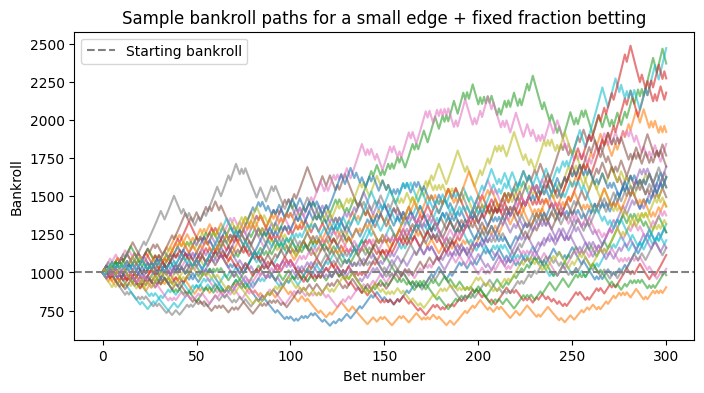

Final bankroll stats:
Mean: 1543.0459737982167
Median: 1526.3460456653993
Min: 903.1235409919661
Max: 2472.5372625093173


In [ ]:
# Bankroll path simulations

def simulate_bankroll_paths(
    n_bets=200,
    n_paths=20,
    decimal_odds=2.1,
    true_p=0.52,
    stake_fraction=0.02,
    initial_bankroll=1000,
    seed=0,
):
    random.seed(seed)
    all_paths = []
    for path in range(n_paths):
        bankroll = initial_bankroll
        path_vals = [bankroll]
        for _ in range(n_bets):
            stake = bankroll * stake_fraction
            if bankroll <= 0:
                path_vals.append(0)
                continue
            if random.random() < true_p:
                bankroll += stake * (decimal_odds - 1)
            else:
                bankroll -= stake
            path_vals.append(bankroll)
        all_paths.append(path_vals)
    return np.array(all_paths)

paths = simulate_bankroll_paths(
    n_bets=300,
    n_paths=30,
    decimal_odds=2.1,
    true_p=0.52,
    stake_fraction=0.02,
    initial_bankroll=1000,
)

for path in paths:
    plt.plot(path, alpha=0.6)
plt.axhline(1000, linestyle="--", color="gray", label="Starting bankroll")
plt.xlabel("Bet number")
plt.ylabel("Bankroll")
plt.title("Sample bankroll paths for a small edge + fixed fraction betting")
plt.legend()
plt.show()

final_bankrolls = paths[:, -1]
print("Final bankroll stats:")
print("Mean:", np.mean(final_bankrolls))
print("Median:", np.median(final_bankrolls))
print("Min:", np.min(final_bankrolls))
print("Max:", np.max(final_bankrolls))

Change `true_p`, `decimal_odds`, `stake_fraction`, and `n_bets` to see how things can go very right or very wrong.

---
## 9. Parlays

A **parlay** combines multiple bets. All legs must win. This multiplies both payout and risk — and usually increases the house edge.

In [ ]:
# Parlay helpers

def parlay_decimal_odds(decimal_odds_list):
    d = 1.0
    for x in decimal_odds_list:
        d *= x
    return d

def parlay_true_prob(prob_list):
    p = 1.0
    for x in prob_list:
        p *= x
    return p

def parlay_ev(decimal_odds_list, prob_list, stake=1.0):
    d_parlay = parlay_decimal_odds(decimal_odds_list)
    p_parlay = parlay_true_prob(prob_list)
    return ev_decimal(d_parlay, p_parlay, stake), d_parlay, p_parlay

# Example: three ~even-ish legs
legs_decimal = [1.9, 1.85, 2.0]
legs_probs_true = [0.53, 0.52, 0.5]  # your model's true probs

ev_p, d_p, p_p = parlay_ev(legs_decimal, legs_probs_true, stake=1.0)
print(f"Parlay decimal odds: {d_p:.3f}")
print(f"Parlay true win probability: {p_p:.4f} ({pct(p_p)}%)")
print(f"Parlay EV per unit stake: {ev_p:.4f} ({pct(ev_p)}% of stake)")

Parlay decimal odds: 7.030
Parlay true win probability: 0.1378 (13.78%)
Parlay EV per unit stake: -0.0313 (-3.13% of stake)


Try making the legs slightly worse (e.g. lower true probabilities) and see how the EV changes.

---
## 10. Wrap-up Playground

This final cell lets you plug in any **American odds** and your own estimate of the true win probability to see:
- Implied probability
- Your edge (difference between true and implied)
- EV per unit bet
- Kelly fraction of bankroll to bet

In [ ]:
# Wrap-up playground

def analyze_bet(american_odds: int, true_p: float, stake: float = 1.0):
    d = american_to_decimal(american_odds)
    p_implied = implied_prob_american(american_odds)
    edge = true_p - p_implied
    ev_unit = ev_decimal(d, true_p, stake=1.0)
    kelly = kelly_fraction_decimal(d, true_p)

    print(f"American odds: {american_odds}")
    print(f"Decimal odds: {d:.4f}")
    print(f"Implied probability: {p_implied:.4f} ({pct(p_implied)}%)")
    print(f"Your true probability: {true_p:.4f} ({pct(true_p)}%)")
    print(f"Edge (true - implied): {edge:.4f} ({pct(edge)} percentage points)")
    print(f"EV per unit stake: {ev_unit:.4f} ({pct(ev_unit)}% of stake)")
    print(f"Full Kelly fraction: {kelly:.4f} ({pct(kelly)}% of bankroll)")

# Try modifying these:
american_odds_input = -120
true_p_input = 0.55
analyze_bet(american_odds_input, true_p_input)

American odds: -120
Decimal odds: 1.8333
Implied probability: 0.5455 (54.55%)
Your true probability: 0.5500 (55.0%)
Edge (true - implied): 0.0045 (0.45 percentage points)
EV per unit stake: 0.0083 (0.83% of stake)
Full Kelly fraction: 0.0100 (1.0% of bankroll)


You now have an interactive notebook that covers:
- Randomness & basic probability
- Odds formats & conversions
- Implied probability
- Vig & overround
- Expected value
- Bankroll management & Kelly
- Variance & drawdowns
- Parlays

You can extend it with:
- Real data from historical games/fights
- Your own models for estimating true probabilities
- More advanced bankroll and risk-of-ruin analytics
